In [1]:
pip install --force-reinstall git+https://github.com/meerakota/ucla_plha.git

  Cloning https://github.com/meerakota/ucla_plha.git to c:\users\sjbra\appdata\local\temp\pip-req-build-6umj1ei6
  Resolved https://github.com/meerakota/ucla_plha.git to commit cb5ad579c799a526234622bc8f6907dadecafa36
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached jsonschema-4.25.1-py3-none-any.whl.metadata (7.6 kB)
  Using cached numpy-2.3.4-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached scipy-1.16.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached attrs-2

  Running command git clone --filter=blob:none --quiet https://github.com/meerakota/ucla_plha.git 'C:\Users\sjbra\AppData\Local\Temp\pip-req-build-6umj1ei6'
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.3.4 which is incompatible.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.2 which is incompatible.

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


# Validation of ground motion models

The purpose of this notebook is to validate our implementation of the four ground motion models. We have gathered images of relevant figures from the original references, and overlaid the corresponding data generated using the ucla_plha code. Alignment of the image and the data plot may not be perfect, but is close enough for validation purposes. Though not provide here, we also validated the mean and standard deviation for each of the ground motion models using Albert Kottke's [pygmm](https://github.com/arkottke/pygmm) package. 

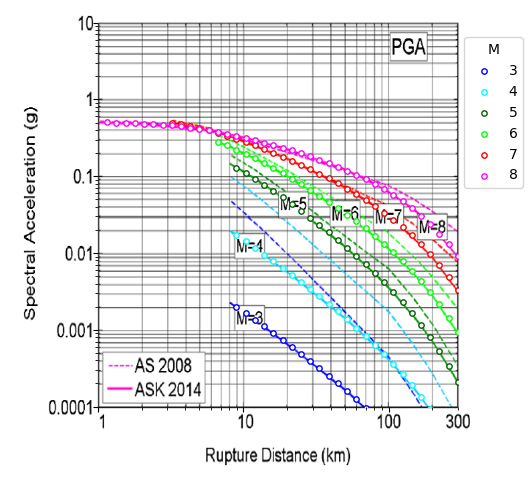

In [2]:
# Reproduce Fig. 8 from ASK model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import ask14

rrup_vec = np.logspace(0, np.log10(300), 40)
m_vec = np.asarray([3, 4, 5, 6, 7, 8])
rrup_lim = np.asarray([8, 8, 8, 6.5, 3.0, 1.0])
ztor_vec = np.asarray([8, 8, 8, 6.5, 3.0, 0.0])
colors = np.asarray(["blue", "cyan", "darkgreen", "lime", "red", "magenta"])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        ztor[I] = ztor_vec[i]
        I += 1

vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
ry0 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
measured_vs30 = True

mu_ln, sigma_ln = ask14.get_im(
    vs30, rrup, rx, rx1, ry0, m, fault_type, measured_vs30, dip, ztor, z1=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 6))

image = mpimg.imread("ask14_validation.png")
ax_img.imshow(image, extent=[0,6,0,6])
ax_img.axis("off")
ax_data = fig.add_axes((0.274,0.219,0.6,0.64), frameon=False)
ax_data.set_xscale('log')
ax_data.set_yscale('log')
for i, m_val in enumerate(m_vec):
    ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=15
    )

ax_data.set_ylim(0.0001, 10)
ax_data.set_xlim(1, 300)

ax_data.legend(title="M", loc='upper right', bbox_to_anchor=(1.2,0.98,0,0))
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

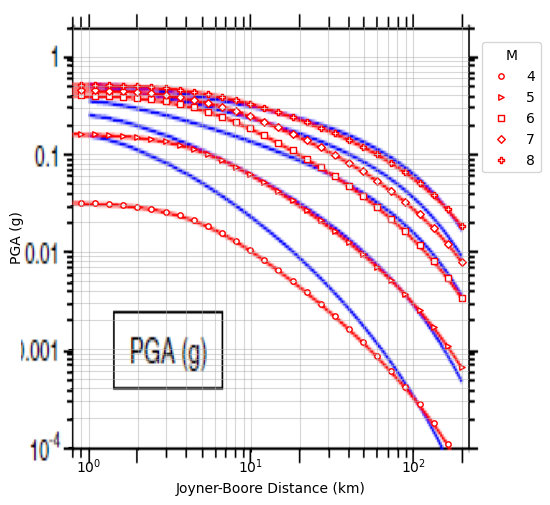

In [3]:
# Reproduce PGA part of Fig. 7 from BSSA14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import bssa14

rjb_vec = np.logspace(np.log(0.8), np.log10(200), 30)
m_vec = np.asarray([4, 5, 6, 7, 8])
rjb = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
m = np.empty(len(m_vec) * len(rjb_vec), dtype=float)
I = 0
for i in range(len(m_vec)):
    for j in range(len(rjb_vec)):
        m[I] = m_vec[i]
        rjb[I] = rjb_vec[j]
        I += 1

vs30 = 760
fault_type = np.full(len(m), 3)

mu_ln, sigma_ln = bssa14.get_im(vs30, rjb, m, fault_type)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 6))
image = mpimg.imread("bssa14_validation.png")
ax_img.imshow(image, extent=[0,6,0,6])
ax_img.axis("off")

markers = ['o', '>', 's', 'D', 'P']

ax_data = fig.add_axes((0.214,0.15,0.659,0.7), frameon=False)
for i, m_val in enumerate(m_vec):
    ax_data.scatter(rjb[m == m_val], pga[m == m_val], label=str(m_val), edgecolor='red', facecolor='white', s=15, marker=markers[i])
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 2)
ax_data.set_xlim(0.8, 220)
ax_data.legend(title="M", loc='upper right', bbox_to_anchor=(1.2,0.98,0,0))
ax_data.grid(True, alpha=0.5, which="both")
ax_data.set_xlabel("Joyner-Boore Distance (km)")
ax_data.set_ylabel("PGA (g)", labelpad=30)
# ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

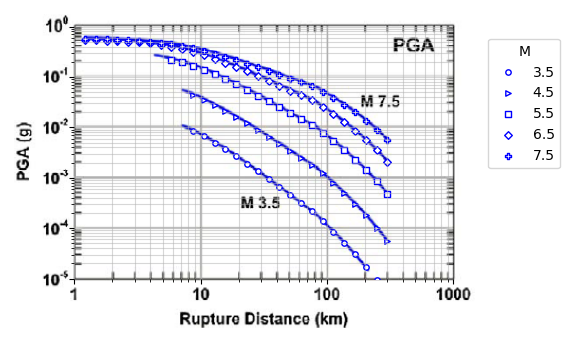

In [4]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cb14

rrup_vec = np.logspace(0, np.log10(300), 30)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5])
rrup_lim = np.asarray([8, 8, 5, 1.0, 1.0])
ztor_vec = np.asarray([8, 8, 5, 0.0, 0.0])
colors = np.asarray(["blue", "cyan", "darkgreen", "lime", "red", "magenta"])
rrup = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
m = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rrup_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
rx = np.full(len(m), 0.0)
rx1 = np.full(len(m), 0.0)
fault_type = np.full(len(m), 3)
for i in range(len(m_vec)):
    for j in range(len(rrup_vec)):
        m[I] = m_vec[i]
        rrup[I] = rrup_vec[j]
        rjb[I] = rrup_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        W = np.sqrt(10 ** ((m[I] - 4.07) / 0.98))
        zhyp[I] = ztor[I] - 0.5 * W * np.sin(dip[I] * np.pi / 180.0)
        zbor[I] = ztor[I] + W
        I += 1


mu_ln, sigma_ln = cb14.get_im(vs30, rjb, rrup, rx, rx1, m, fault_type, ztor, zbor, dip)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 6))

image = mpimg.imread("cb14_validation.png")
ax_img.imshow(image)
ax_img.axis("off")
markers = ['o', '>', 's', 'D', 'P']
ax_data = fig.add_axes((0.232,0.317,0.632,0.42), frameon=False)
for i, m_val in enumerate(m_vec):
    ax_data.scatter(
        rrup[(m == m_val) & (rrup > rrup_lim[i])],
        pga[(m == m_val) & (rrup > rrup_lim[i])],
        label=str(m_val),
        facecolor = 'white',
        edgecolor = 'blue',
        marker = markers[i],
        s = 15
    )
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.00001, 1)
ax_data.set_xlim(1, 1000)
ax_data.legend(title="M", loc='upper right', bbox_to_anchor=(1.3,0.98,0,0))
ax_data.grid(True, alpha=0.5, which="both")
# ax_data.set_xlabel("Rupture Distance (km)")
# ax_data.set_ylabel("PGA (g)")
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)

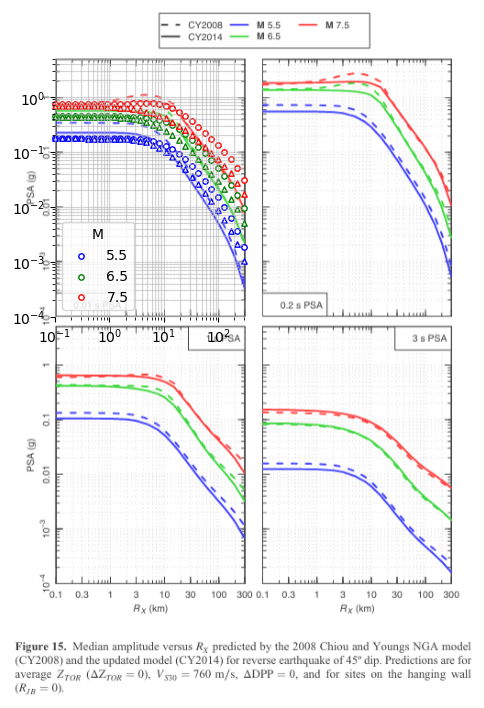

In [12]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cy14
import pygmm

rx_vec = np.logspace(-1, np.log10(300), 30)
m_vec = np.asarray([5.5, 6.5, 7.5])
rrup = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rx = np.empty(len(m_vec) * len(rx_vec), dtype=float)
m = np.empty(len(m_vec) * len(rx_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 45.0)
fault_type = np.full(len(m), 1)
pga_pygmm = np.zeros(len(m))
for i in range(len(m_vec)):
    for j in range(len(rx_vec)):
        m[I] = m_vec[i]
        rx[I] = rx_vec[j]
        rjb[I] = 0.0
        ztor[I] = np.max([2.704 - 1.226 * np.max([m[I] - 5.849, 0]), 0]) ** 2
        if(rx[I] > ztor[I]):
            rrup[I] = (rx[I] + ztor[I]) / np.sqrt(2)
        else:
            rrup[I] = np.sqrt(rx[I] ** 2 + ztor[I] ** 2)
        s = pygmm.model.Scenario(
            mag = m[I], dist_jb = rjb[I], dist_x = rx[I], dist_rup = rrup[I], dip = dip[I], v_s30 = vs30, mechanism='RS'
        )
        pygmm_output = pygmm.ChiouYoungs2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1

measured_vs30 = False
mu_ln, sigma_ln = cy14.get_im(
    vs30, rjb, rrup, rx, m, fault_type, measured_vs30, dip, ztor, z1p0=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 10))

image = mpimg.imread("cy14_validation_rv_fig15.png")
ax_img.imshow(image, alpha=0.75)
ax_img.axis("off")
colors = ['blue', 'green', 'red']
ax_data = fig.add_axes((0.2,0.532,0.315,0.258), frameon=False)
for i, m_val in enumerate(m_vec):
    ax_data.scatter(
        rx[m == m_val],
        pga[m == m_val],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=15,
        clip_on = False
    )
    ax_data.scatter(
        rx[m == m_val],
        pga_pygmm[m == m_val],
        edgecolor=colors[i],
        facecolor='white',
        s=15,
        clip_on = False,
        marker = '^'
    )
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 5)
ax_data.set_xlim(0.1, 300)
ax_data.legend(title="M")
ax_data.grid(True, alpha=0.5, which="both")
# ax[1].set_xlabel("Rupture Distance (km)")
# ax[1].set_ylabel("PGA (g)")

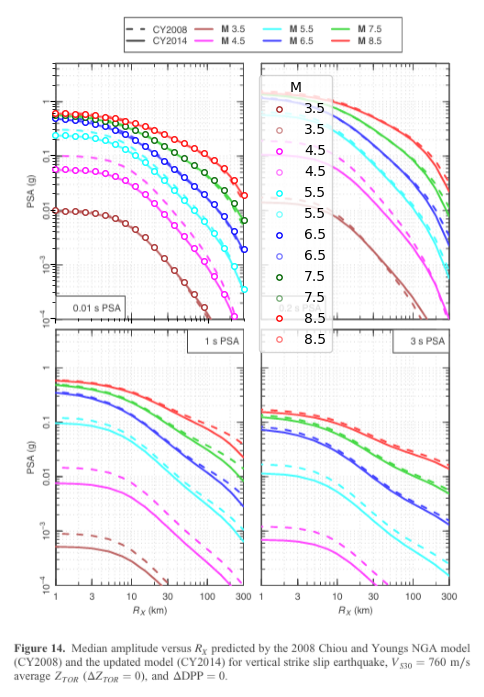

In [9]:
# Reproduce Fig. 6 from CB14 model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ucla_plha.ground_motion_models import cy14

rx_vec = np.logspace(0, np.log10(300), 20)
m_vec = np.asarray([3.5, 4.5, 5.5, 6.5, 7.5, 8.5])
colors = np.asarray(["brown", "magenta", "cyan", "blue", "darkgreen", "red"])
rrup = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rjb = np.empty(len(m_vec) * len(rx_vec), dtype=float)
rx = np.empty(len(m_vec) * len(rx_vec), dtype=float)
m = np.empty(len(m_vec) * len(rx_vec), dtype=float)
ztor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zhyp = np.empty(len(m_vec) * len(rx_vec), dtype=float)
zbor = np.empty(len(m_vec) * len(rx_vec), dtype=float)
I = 0
vs30 = 760
dip = np.full(len(m), 90.0)
fault_type = np.full(len(m), 3)
pga_pygmm = np.zeros(len(m))
for i in range(len(m_vec)):
    for j in range(len(rx_vec)):
        m[I] = m_vec[i]
        rx[I] = rx_vec[j]
        rjb[I] = rx_vec[j]
        ztor[I] = np.max([2.673 - 1.136 * np.max([m[I] - 4.970, 0]), 0]) ** 2
        rrup[I] = np.sqrt(rx[I] ** 2 + ztor[I] ** 2)
        s = pygmm.model.Scenario(
            mag = m[I], dist_jb = rjb[I], dist_x = rx[I], dist_rup = rrup[I], dip = dip[I], v_s30 = vs30, mechanism='SS'
        )
        pygmm_output = pygmm.ChiouYoungs2014(s)
        pga_pygmm[I] = pygmm_output.spec_accels[0]
        I += 1

measured_vs30 = False
mu_ln, sigma_ln = cy14.get_im(
    vs30, rjb, rrup, rx, m, fault_type, measured_vs30, dip, ztor, z1p0=None
)
pga = np.exp(mu_ln)

fig, ax_img = plt.subplots(figsize=(6, 10))

image = mpimg.imread("cy14_validation_fig14.png")
ax_img.imshow(image, alpha=0.75)
ax_img.axis("off")
ax_data = fig.add_axes((0.2,0.525,0.315,0.255), frameon=False)
for i, m_val in enumerate(m_vec):
    ax_data.scatter(
        rx[(m == m_val) & (pga > 1.e-4)],
        pga[(m == m_val) & (pga > 1.e-4)],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=15,
        clip_on = False
    )
    ax_data.scatter(
        rx[(m == m_val) & (pga > 1.e-4)],
        pga_pygmm[(m == m_val) & (pga > 1.e-4)],
        label=str(m_val),
        edgecolor=colors[i],
        facecolor='white',
        s=15,
        clip_on = False,
        alpha=0.5
    )
ax_data.set_yscale("log")
ax_data.set_xscale("log")
ax_data.set_ylim(0.0001, 5)
ax_data.set_xlim(1, 300)
ax_data.legend(title="M", loc='upper right', bbox_to_anchor=(1.5,0.98,0,0))
ax_data.tick_params(axis='x', labelbottom=False)
ax_data.tick_params(axis='y', labelleft=False)